# Построение модели определения стоимости автомобиля



Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as ltb
from sklearn.dummy import DummyRegressor  # константная модель

plt.rcParams['figure.figsize'] = (8,5)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

In [3]:
pth1 = '/datasets/autos.csv'
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
def data_describe(data):
    print('Общая информация:')
    data.info()
    print('Первые 5 строк:')
    display(data.head())
    print('Описание датафрейма:')
    display(data.describe())
    print('Пропуски:')
    display(data.isna().sum().sort_values(ascending=False))
    print('Дубликаты:')
    display(data.duplicated().sum())
    print('Уникальные значения:')
    display(data.nunique().sort_values())
    print('Разделим признаки на категориальные и числовые:')
    num_columns = []
    cat_columns = []
    for num, i in enumerate(data.columns):
        if pd.api.types.is_numeric_dtype(data[i]):
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(data[i]):
            cat_columns.append(i)
    print('Всего числовых признаков:', len(num_columns))
    print('Всего категориальных признаков:', len(cat_columns))

In [5]:
data_describe(df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes:

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Описание датафрейма:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Пропуски:


Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Дубликаты:


4

Уникальные значения:


NumberOfPictures          1
Gearbox                   2
Repaired                  2
FuelType                  7
VehicleType               8
Kilometer                13
RegistrationMonth        13
Brand                    40
DateCreated             109
RegistrationYear        151
Model                   250
Power                   712
Price                  3731
PostalCode             8143
LastSeen             179150
DateCrawled          271174
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 7
Всего категориальных признаков: 9


Опишем признаки:

**Признаки**


DateCrawled — дата скачивания анкеты из базы <br>
VehicleType — тип автомобильного кузова <br>
RegistrationYear — год регистрации автомобиля <br>
Gearbox — тип коробки передач <br>
Power — мощность (л. с.) <br>
Model — модель автомобиля <br>
Kilometer — пробег (км) <br>
RegistrationMonth — месяц регистрации автомобиля <br>
FuelType — тип топлива <br>
Brand — марка автомобиля <br>
Repaired — была машина в ремонте или нет <br>
DateCreated — дата создания анкеты <br>
NumberOfPictures — количество фотографий автомобиля <br>
PostalCode — почтовый индекс владельца анкеты (пользователя) <br>
LastSeen — дата последней активности пользователя <br>

**Целевой признак**


Price — цена (евро)


Определим важные для прогнозирования цены признаки: `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`, `Kilometer`, `FuelType`, `Brand`, `Repaired`

Признаки `NumberOfPictures`, `PostalCode` и `RegistrationMonth` не несут полезной информации, их можно удалить.

Признаки `DateCrawled` и `LastSeen` пригодились бы для прогнозирования, например, скорости продажи, в рамках нашего же исследования они также не несут полезной информации.

`DateCreated` может быть полезна для анализа с учетом инфляции

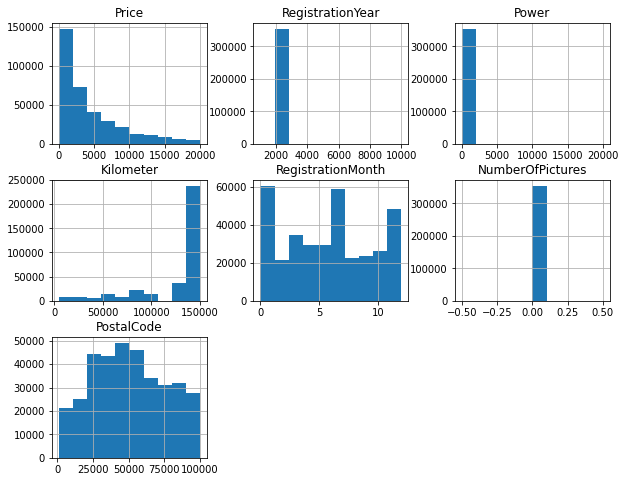

In [6]:
df.hist(figsize=(10,8));

По пяти важным признакам есть пропуски, также присутствуют нулевые значения. Перед работой с моделями необходимо будет обработать признаки (восстановить их или удалить). Присутствуют аномалии и дубликаты

Посмотрим на количество нулевых значений у целевого признака и у признака мощности:

In [7]:
df['Price'].value_counts().sort_values(ascending=False)

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
19770        1
1587         1
2101         1
16444        1
8188         1
Name: Price, Length: 3731, dtype: int64

In [8]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [9]:
df['Power'].value_counts().sort_values(ascending=False)

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
604          1
10000        1
1771         1
7529         1
1158         1
Name: Power, Length: 712, dtype: int64

In [10]:
df['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Нулевые значения преобладают, что является аномалией. Потребуется обработка этих значений

Определим промежуток дат объявлений в наборе данных для дальнейшей работы с выбросами

In [11]:
print(df['DateCreated'].min())
print(df['DateCreated'].max())

2014-03-10 00:00:00
2016-04-07 00:00:00


Данные содержат объявления, размещенные за более чем 2 года, начиная с 10 марта 2014 года по 7 апреля 2016 года

**Выводы:**
- исходный датафрейм содержит 16 стобцов (7 числовых признаков и 9 категориальных) и 354369 записей
- столбцы с датами `DateCrawled`, `DateCreated` и `LastSeen` необходимо привести к формату даты и времени
- присутствуют пропуски в 5 столбцах `Repaired`, `VehicleType`, `FuelType`, `Gearbox`, `Model`
- неявные пропуски присутствуют в `RegistrationMonth`, `Power` и `Price`
- имеется 4 явных дубликата
- присутствуют аномалии в столбцах `RegistrationYear` и `Power`
- максимальное значение в столбце `Kilometer` ограничивается значением 150000
- во всех признаках отсутствуют фотографии в столбце `NumberOfPictures`

## Предобработка данных

Предобработку данных начнем с целевого признака цены. Пропусков у таргета нет, но есть цена равная нулю. Проверим другие значения:

In [12]:
df['Price'].value_counts().sort_values(ascending=False)

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
19770        1
1587         1
2101         1
16444        1
8188         1
Name: Price, Length: 3731, dtype: int64

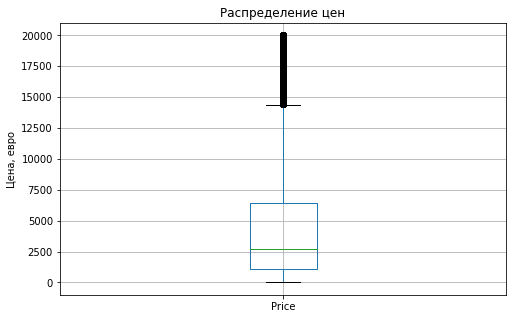

In [13]:
df['Price'].plot(kind='box', title='Распределение цен', grid=True)
plt.ylabel('Цена, евро')
plt.show()

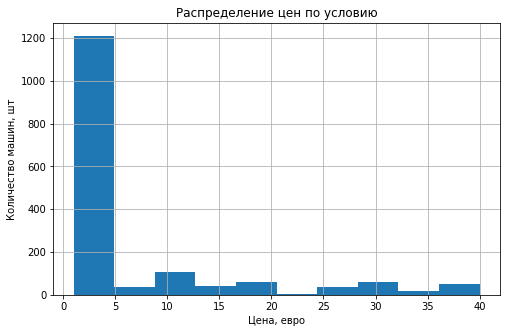

In [14]:
df[(df['Price'] != 0) & (df['Price'] < df['Price'].quantile(0.035))]['Price'].hist()

plt.title('Распределение цен по условию')
plt.xlabel('Цена, евро')
plt.ylabel('Количество машин, шт')

plt.show()

In [15]:
df[(df['Price'] != 0) & (df['Price'] < df['Price'].quantile(0.035))]['Price'].value_counts()

1     1189
10      84
30      55
20      51
40      45
25      33
15      27
5       26
35      18
2       12
8        9
9        8
12       8
3        8
13       7
39       6
11       5
14       5
17       5
7        3
18       3
19       3
29       2
16       2
24       1
26       1
27       1
21       1
32       1
33       1
38       1
4        1
Name: Price, dtype: int64

In [16]:
df = df.loc[df['Price'] > df['Price'].quantile(0.035)]

Цены меньше 3,5% квантиля в 45 евро будем считать аномальными и удалим эти записи.
Восстановить все аномальные значения средним было бы некорректно, так как признак целевой и это напрямую повлияет на прогноз

Избавимся от дубликатов

In [17]:
df.duplicated().sum()

4

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df.duplicated().sum()

0

Удалим столбцы, не несущие информации об объектах

In [20]:
df['NumberOfPictures'].value_counts()

0    341955
Name: NumberOfPictures, dtype: int64

In [21]:
df.drop(columns=['NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1, inplace=True)

Проведем работу с выбросами. Согласно статистической сводке в данных присутствуют ошибочные записи: 9999 год регистрации автомобиля или бешеная мощность автомобиля в 20000 л.с. Такие объекты стоит исключить

Найдем количество записей с аномальным годом регистрации:

In [22]:
len(df[df['RegistrationYear'] > 2016])

13705

In [23]:
np.sort(df['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8000, 8200, 8500, 8888, 9000, 9450, 9999])

Из ранее определенного временного диапазона размещения объявлений следует, что объявления о продаже автомобилей, которые были выпущены слишком рано или в слишком далеком будущем, являются ошибочными (или содержат ошибочную информацию), поэтому удалим их.

Если с верхней временной границей все довольно очевидно: отсечём объявления на момент последней выгрузки информации (2016-04-07 00:00:00), то с нижней ещё стоит определиться.

Ее установим исходя из того, насколько много было автомобилей с конкретным годом выпуска. Посмотрим на график зависимости количества объявлений от года выпуска авто.

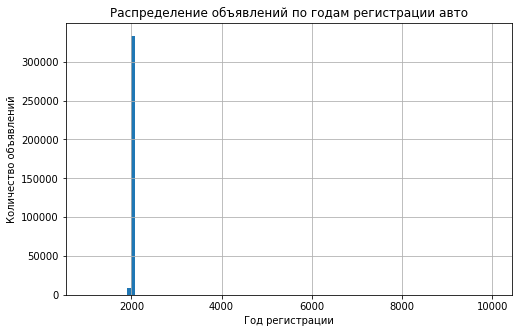

In [24]:
df['RegistrationYear'].hist(bins=100)

plt.title('Распределение объявлений по годам регистрации авто')
plt.xlabel('Год регистрации')
plt.ylabel('Количество объявлений')

plt.show()

In [25]:
len(df[df['RegistrationYear'] < 1980])

3088

Итак, нижней границей выберем 1980 год, так как количество продаваемых автомобилей начинает увеличиваться примерно с этой отметки.

Все автомобили, произведенные ранее и выставленные на продажу, может и представляют интерес для коллекционеров, но все же оценка стоимости раритетных автомобилей не приоритетная цель разработки нашего алгоритма.

Верхняя граница, как уже говорилось ранее, будет выбрана согласно дате последнего размещенного объявления.

Год регистрации авто на практике важный параметр, между вариантом заполнения аномальных значений средним и избавлением от записей выберем последний, количество аномальных записей позволяет сделать это.

Уберем ненужные объявления:

In [26]:
df = df[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] >= 1980)]

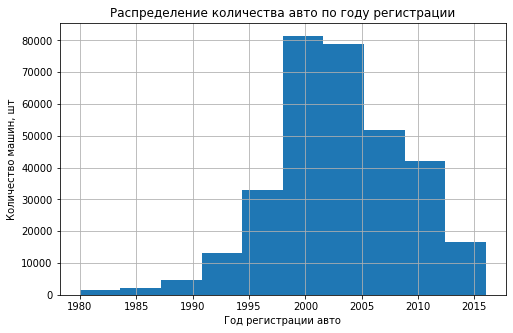

In [27]:
df['RegistrationYear'].hist()

plt.title('Распределение количества авто по году регистрации')
plt.xlabel('Год регистрации авто')
plt.ylabel('Количество машин, шт')

plt.show()

In [28]:
df['Power'].value_counts().sort_values(ascending=False)

0       31230
75      21996
60      14638
150     13657
101     12365
        ...  
1256        1
1288        1
489         1
2792        1
6006        1
Name: Power, Length: 677, dtype: int64

In [29]:
df['Power'].describe()

count    325162.000000
mean        112.442582
std         183.621165
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [30]:
df['Power'].quantile(0.998)

400.0

Значения `Power` равные 0 и больше 1000 являются некорректным, у нас нет оснований думать, что остальные призанки в этом наблюдении также в порядке. Удалим невалидные наблюдения

In [31]:
df = df[~((df['Power'] > 1000) | (df['Power'] == 0))]

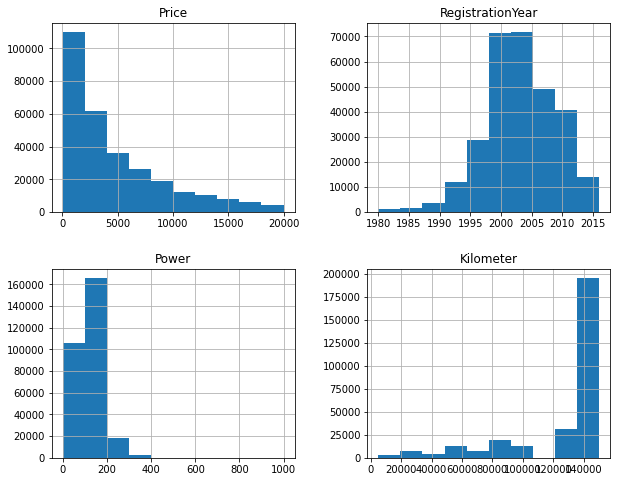

In [32]:
df.hist(figsize=(10,8));

Далее обработаем пропуски:

Как мы уже выяснили они присутствуют в 5 столбцах Repaired, VehicleType, FuelType, Gearbox, Model

In [33]:
df.isna().sum().sort_values(ascending=False)

Repaired            42293
FuelType            15293
VehicleType         10862
Model               10680
Gearbox              5232
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
Brand                   0
dtype: int64

Пропуски в `Model` восстановить не получится, заменим их на 'no info'

In [34]:
df['Model'] = df['Model'].fillna('no info')

Пропуски в `FuelType` заменим на среднее по моделям

In [35]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

Количество пропусков в `VehicleType` достаточно велико - более 10 процентов. Если пропуски заменить на среднее значение, это может сказаться на точности предсказания. В дальнейшем пользователи при оценке автомобиля могут так же не вводить тип кузова, стоит заменить пропущенные значения на 'no info'

In [36]:
df['VehicleType'] = df['VehicleType'].fillna('no info')

Пропуски в `Gearbox` заменим на наиболее встречающийся тип коробки в модели

In [37]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))

Пропусков в `Repaired` наибольшее количество ~ 20% от данных. Можно выдвинуть предположение, что этот параметр не заполнялся, если автомобиль не был в ремонте. Однако пропуски возможны и по иным причинам, когда продавец не желает изначально давать информацию о том, что автомобиль был в ремонте. Заполним пропуски в этом параметре как 'no info'

In [38]:
df['Repaired'] = df['Repaired'].fillna('no info')

In [39]:
df.isna().sum().sort_values(ascending=False)

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293676 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             293676 non-null  int64 
 1   VehicleType       293676 non-null  object
 2   RegistrationYear  293676 non-null  int64 
 3   Gearbox           293676 non-null  object
 4   Power             293676 non-null  int64 
 5   Model             293676 non-null  object
 6   Kilometer         293676 non-null  int64 
 7   FuelType          293676 non-null  object
 8   Brand             293676 non-null  object
 9   Repaired          293676 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.6+ MB


In [41]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,293676.000000,293676.000000,293676.000000,293676.000000
mean,4842.061827,2003.063778,120.872237,128536.942072
std,4596.146520,5.911542,54.577192,36532.482632
min,47.000000,1980.000000,1.000000,5000.000000
25%,1350.000000,1999.000000,76.000000,125000.000000
50%,3199.000000,2003.000000,111.000000,150000.000000
75%,6990.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1000.000000,150000.000000


**Выводы:**
- удалили 4 явных дубликата
- убрали столбцы, не дающие важной информации для предсказания цены: `NumberOfPictures`, `PostalCode`, `DateCrawled`, `LastSeen`, `RegistrationMonth`
- обработали пропуски в 5 столбцах `Repaired`, `VehicleType`, `FuelType`, `Gearbox`, `Model`
- обработали аномалии в столбцах `RegistrationYear` и `Power`, оставив записи, заполнив выбросы одним значением

## Обучение моделей

Разделим датасет на 3 части в соотношении 3:1:1 (60% обучающая выборка, 20% валидационная и 20% тестовая). Значение аргумента shuffle=False, так как данные отсортированы во временной последовательности размещения объявлений

In [42]:
# создадим признаки
features = df.drop('Price', axis=1)
target = df['Price']

# создадим обучающую выборку и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE, shuffle=False)

# разделим валидационную пополам - получим тестовую выборку
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=RANDOM_STATE)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_valid) / len(df))
print(len(features_test) / len(df))

(176205, 9)
(58735, 9)
(58736, 9)
0.5999979569321293
0.19999931897737644
0.2000027240904943


**Кодирование категориальных признаков**

У числовых признаков в наборе данных разные диапазоны, что может привести к ситуации, когда один из признаков окажется более важен не по объективным причинам, а за счет масштаба. Приведем признаки к единому масштабу.

Категориальные признаки перекодируем в числовые с помощью One-Hot Encoding.

In [43]:
#создадим список категориальных признаков:
categorial_features = df.select_dtypes(include='object').columns.to_list()
print('Cписок категориальных признаков:', categorial_features)

#создадим список числовых признаков и удалим из него бинарные признаки:
num_features = df.drop(['Price'], axis=1).select_dtypes(exclude='object').columns.to_list()
print('Cписок числовых признаков:', num_features)

Cписок категориальных признаков: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
Cписок числовых признаков: ['RegistrationYear', 'Power', 'Kilometer']


**Сравнение моделей с константной моделью**

Построим регрессор в качестве простого базиса, с ним будем сравнивать результаты других моделей обучения

In [44]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(target_test, dummy_predict, squared=False)
print('RMSE для константной модели на тестовой выборке:', round(rmse_dummy))

RMSE для константной модели на тестовой выборке: 4593


In [45]:
# кодирование категориальных признаков
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train[categorial_features])
features_train[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train[categorial_features])

features_train = features_train.drop(categorial_features, axis=1)
print(features_train.head())

   RegistrationYear  Power  Kilometer  x0_convertible  x0_coupe  x0_no info  \
1              2011    190     125000             0.0       1.0         0.0   
2              2004    163     125000             0.0       0.0         0.0   
3              2001     75     150000             0.0       0.0         0.0   
4              2008     69      90000             0.0       0.0         0.0   
5              1995    102     150000             0.0       0.0         0.0   

   x0_other  x0_sedan  x0_small  x0_suv  ...  x4_smart  x4_sonstige_autos  \
1       0.0       0.0       0.0     0.0  ...       0.0                0.0   
2       0.0       0.0       0.0     1.0  ...       0.0                0.0   
3       0.0       0.0       1.0     0.0  ...       0.0                0.0   
4       0.0       0.0       1.0     0.0  ...       0.0                0.0   
5       0.0       1.0       0.0     0.0  ...       0.0                0.0   

   x4_subaru  x4_suzuki  x4_toyota  x4_trabant  x4_volkswagen 

In [46]:
# стандартизация (масштабирование) непрерывных признаков
scaler = StandardScaler()
features_train[num_features] = scaler.fit_transform(features_train[num_features])
print('Размер выборки:', features_train.shape)
print(features_train.head())

Размер выборки: (176205, 307)
   RegistrationYear     Power  Kilometer  x0_convertible  x0_coupe  \
1          1.337827  1.261053  -0.095819             0.0       1.0   
2          0.155488  0.768588  -0.095819             0.0       0.0   
3         -0.351228 -0.836481   0.588188             0.0       0.0   
4          0.831110 -0.945917  -1.053429             0.0       0.0   
5         -1.364661 -0.344016   0.588188             0.0       0.0   

   x0_no info  x0_other  x0_sedan  x0_small  x0_suv  ...  x4_smart  \
1         0.0       0.0       0.0       0.0     0.0  ...       0.0   
2         0.0       0.0       0.0       0.0     1.0  ...       0.0   
3         0.0       0.0       0.0       1.0     0.0  ...       0.0   
4         0.0       0.0       0.0       1.0     0.0  ...       0.0   
5         0.0       0.0       1.0       0.0     0.0  ...       0.0   

   x4_sonstige_autos  x4_subaru  x4_suzuki  x4_toyota  x4_trabant  \
1                0.0        0.0        0.0        0.0      

In [47]:
# трансформируем валидационную выборку
features_valid[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_valid[categorial_features])

features_valid = features_valid.drop(categorial_features, axis=1)

features_valid[num_features] = scaler.transform(features_valid[num_features])

print('Валидационная выборка:', features_valid.shape)
print(features_valid.head())

Валидационная выборка: (58735, 307)
        RegistrationYear     Power  Kilometer  x0_convertible  x0_coupe  \
300433         -2.040283  1.808235   0.588188             0.0       1.0   
348438          1.000016  0.713870  -1.327032             1.0       0.0   
338903         -0.520134  0.896264   0.588188             0.0       0.0   
226949          0.662205  0.349082   0.588188             0.0       0.0   
212777         -2.040283 -0.143383   0.588188             0.0       0.0   

        x0_no info  x0_other  x0_sedan  x0_small  x0_suv  ...  x4_smart  \
300433         0.0       0.0       0.0       0.0     0.0  ...       0.0   
348438         0.0       0.0       0.0       0.0     0.0  ...       0.0   
338903         0.0       0.0       1.0       0.0     0.0  ...       0.0   
226949         0.0       0.0       0.0       0.0     0.0  ...       0.0   
212777         0.0       0.0       1.0       0.0     0.0  ...       0.0   

        x4_sonstige_autos  x4_subaru  x4_suzuki  x4_toyota  x4

Повторим константную модель на данных после кодирования и масштабирования признаков

In [48]:
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(target_test, dummy_predict, squared=False)
print('RMSE для константной модели на тестовой выборке:', round(rmse_dummy))

RMSE для константной модели на тестовой выборке: 4593


**Linear Regression**

In [49]:
%%time

lmodel = LinearRegression()
lmodel.fit(features_train, target_train)

CPU times: user 11.5 s, sys: 3.78 s, total: 15.2 s
Wall time: 15.3 s


LinearRegression()

In [50]:
%%time

pred_lmodel = lmodel.predict(features_valid)

CPU times: user 96.9 ms, sys: 108 ms, total: 205 ms
Wall time: 196 ms


In [51]:
rmse_lmodel = mean_squared_error(target_valid, pred_lmodel, squared=False)
print('RMSE для LinearRegression на валидационной выборке:', round(rmse_lmodel))

RMSE для LinearRegression на валидационной выборке: 2388


Ранее использованная техника кодирования OneHotEncoder() увеличивает количество признаков, в результате чего следующим используемым моделям сложнее будет создавать разделяющие правила, поэтому время работы и расчётные характеристики моделей сильно страдают на больших наборах данных.

Вместо этого используем OrdinalEncoder() - эта техника кодирует категориальные признаки так, что с ними удобнее работать в ходе создания разделяющих правил

In [52]:
# создадим признаки
features = df.drop('Price', axis=1)
target = df['Price']

# создадим обучающую выборку и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE, shuffle=False)

# разделим валидационную пополам - получим тестовую выборку
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=RANDOM_STATE)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_valid) / len(df))
print(len(features_test) / len(df))

(176205, 9)
(58735, 9)
(58736, 9)
0.5999979569321293
0.19999931897737644
0.2000027240904943


In [53]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [54]:
features_train[categorial_features] = encoder.fit_transform(features_train[categorial_features])

features_valid[categorial_features] = encoder.transform(features_valid[categorial_features])

In [55]:
print('Тренировочная выборка:', features_train.shape)
print(features_train.head())
print('Валидационная выборка:', features_valid.shape)
print(features_valid.head())
print('Тестовая выборка:', features_test.shape)
print(features_test.head())

Тренировочная выборка: (176205, 9)
   VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  FuelType  \
1          2.0              2011      1.0    190  161.0     125000       2.0   
2          7.0              2004      0.0    163  117.0     125000       2.0   
3          6.0              2001      1.0     75  116.0     150000       6.0   
4          6.0              2008      1.0     69  101.0      90000       2.0   
5          5.0              1995      1.0    102   11.0     150000       6.0   

   Brand  Repaired  
1    1.0       2.0  
2   14.0       1.0  
3   38.0       0.0  
4   31.0       0.0  
5    2.0       2.0  
Валидационная выборка: (58735, 9)
        VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  \
300433          2.0              1991      0.0    220  167.0     150000   
348438          1.0              2009      1.0    160  224.0      80000   
338903          5.0              2000      1.0    170   59.0     150000   
226949          0.0     

In [56]:
# стандартизация (масштабирование) непрерывных признаков
scaler = StandardScaler()
features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])

In [57]:
print('Тренировочная выборка:', features_train.shape)
print(features_train.head())
print('Валидационная выборка:', features_valid.shape)
print(features_valid.head())
print('Тестовая выборка:', features_test.shape)
print(features_test.head())

Тренировочная выборка: (176205, 9)
   VehicleType  RegistrationYear  Gearbox     Power  Model  Kilometer  \
1          2.0          1.337827      1.0  1.261053  161.0  -0.095819   
2          7.0          0.155488      0.0  0.768588  117.0  -0.095819   
3          6.0         -0.351228      1.0 -0.836481  116.0   0.588188   
4          6.0          0.831110      1.0 -0.945917  101.0  -1.053429   
5          5.0         -1.364661      1.0 -0.344016   11.0   0.588188   

   FuelType  Brand  Repaired  
1       2.0    1.0       2.0  
2       2.0   14.0       1.0  
3       6.0   38.0       0.0  
4       2.0   31.0       0.0  
5       6.0    2.0       2.0  
Валидационная выборка: (58735, 9)
        VehicleType  RegistrationYear  Gearbox     Power  Model  Kilometer  \
300433          2.0         -2.040283      0.0  1.808235  167.0   0.588188   
348438          1.0          1.000016      1.0  0.713870  224.0  -1.327032   
338903          5.0         -0.520134      1.0  0.896264   59.0   0.5881

**DecisionTreeRegressor**

In [58]:
%%time

best_model = None
best_model_depth = 0
best_model_leaf = 0
best_result = round(rmse_lmodel)

for depth in range(1, 20):
    for i in range(1, 40):
            model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=i)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = mean_squared_error(target_valid, predictions, squared=False)
            if result < best_result:
                best_model = model
                best_model_depth = depth
                best_model_leaf = i
                best_result = result
print('Лучший результат RMSE для DecisionTreeRegressor на валидационной выборке:', best_result)
print('Гиперпараметры:', 'max_depth:', best_model_depth, ', min_samples_leaf:', best_model_leaf)

Лучший результат RMSE для DecisionTreeRegressor на валидационной выборке: 1701.907775148783
Гиперпараметры: max_depth: 19 , min_samples_leaf: 8
CPU times: user 3min 38s, sys: 297 ms, total: 3min 38s
Wall time: 3min 38s


In [59]:
%%time

trmodel = DecisionTreeRegressor(random_state=RANDOM_STATE,
                                max_depth=best_model_depth,
                                min_samples_leaf=best_model_leaf)
trmodel.fit(features_train, target_train)

CPU times: user 467 ms, sys: 7.56 ms, total: 475 ms
Wall time: 485 ms


DecisionTreeRegressor(max_depth=19, min_samples_leaf=8, random_state=12345)

In [60]:
%%time

pred_trmodel = trmodel.predict(features_valid)

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 15.5 ms


In [61]:
rmse_trmodel = mean_squared_error(target_valid, pred_trmodel, squared=False)
print('RMSE для DecisionTreeRegressor на валидационной выборке:', round(rmse_trmodel))

RMSE для DecisionTreeRegressor на валидационной выборке: 1702


**CatBoostRegressor**

Далее для моделей CatBoostRegressor и LGBMRegressor не потребуется масштабирование непрерывных признаков и кодирование категориальных, снова разделим данные на выборки

In [62]:
# создадим признаки
features = df.drop('Price', axis=1)
target = df['Price']

# создадим обучающую выборку и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE, shuffle=False)

# разделим валидационную пополам - получим тестовую выборку
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=RANDOM_STATE)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_valid) / len(df))
print(len(features_test) / len(df))

(176205, 9)
(58735, 9)
(58736, 9)
0.5999979569321293
0.19999931897737644
0.2000027240904943


In [63]:
%%time

catmodel = CatBoostRegressor(cat_features=categorial_features,
                             eval_metric='RMSE',
                             random_state=RANDOM_STATE,
                             verbose=100) # выводится каждая 100 итерация
catmodel.fit(features_train, target_train, eval_set=(features_valid, target_valid))

Learning rate set to 0.114689
0:	learn: 4256.9674782	test: 4212.9389889	best: 4212.9389889 (0)	total: 334ms	remaining: 5m 33s
100:	learn: 1686.8709752	test: 1666.1276379	best: 1666.1276379 (100)	total: 17s	remaining: 2m 31s
200:	learn: 1611.5235607	test: 1601.3785285	best: 1601.3785285 (200)	total: 33.1s	remaining: 2m 11s
300:	learn: 1576.2357996	test: 1574.2233941	best: 1574.2233941 (300)	total: 49s	remaining: 1m 53s
400:	learn: 1550.1242339	test: 1555.6818967	best: 1555.6541516 (399)	total: 1m 4s	remaining: 1m 36s
500:	learn: 1531.5653571	test: 1542.7769215	best: 1542.7769215 (500)	total: 1m 20s	remaining: 1m 19s
600:	learn: 1515.4338060	test: 1533.6871450	best: 1533.6871450 (600)	total: 1m 37s	remaining: 1m 4s
700:	learn: 1502.0125854	test: 1526.4728055	best: 1526.4728055 (700)	total: 1m 53s	remaining: 48.6s
800:	learn: 1489.7979161	test: 1519.8456185	best: 1519.8456185 (800)	total: 2m 10s	remaining: 32.5s
900:	learn: 1478.0933131	test: 1513.5507795	best: 1513.5507795 (900)	total: 2

In [64]:
%%time

cat_predict = catmodel.predict(features_valid)

CPU times: user 427 ms, sys: 0 ns, total: 427 ms
Wall time: 429 ms


In [65]:
rmse_catmodel = mean_squared_error(target_valid, cat_predict, squared=False)
print('RMSE для CatBoostRegressor на валидационной выборке:', round(rmse_catmodel))

RMSE для CatBoostRegressor на валидационной выборке: 1509


Результат этой модели лучше. Оптимизируем гиперпараметры

Уменьшим learning rate

In [66]:
%%time

catmodel = CatBoostRegressor(cat_features=categorial_features,
                             eval_metric='RMSE',
                             learning_rate = 0.02,
                             random_state=RANDOM_STATE,
                             verbose=100) # выводится каждая 100 итерация
catmodel.fit(features_train, target_train, eval_set=(features_valid, target_valid))

0:	learn: 4546.1740834	test: 4500.2364593	best: 4500.2364593 (0)	total: 251ms	remaining: 4m 10s
100:	learn: 2126.2038611	test: 2090.0674253	best: 2090.0674253 (100)	total: 19.1s	remaining: 2m 50s
200:	learn: 1839.3928095	test: 1807.5614322	best: 1807.5614322 (200)	total: 34.5s	remaining: 2m 17s
300:	learn: 1766.9420038	test: 1738.0542111	best: 1738.0542111 (300)	total: 50.8s	remaining: 1m 57s
400:	learn: 1728.4961977	test: 1702.1547566	best: 1702.1547566 (400)	total: 1m 6s	remaining: 1m 39s
500:	learn: 1700.2669444	test: 1676.0355788	best: 1676.0355788 (500)	total: 1m 22s	remaining: 1m 21s
600:	learn: 1678.5930862	test: 1655.9819552	best: 1655.9819552 (600)	total: 1m 38s	remaining: 1m 5s
700:	learn: 1660.7748015	test: 1640.2653240	best: 1640.2653240 (700)	total: 1m 54s	remaining: 48.8s
800:	learn: 1645.7491664	test: 1626.3812311	best: 1626.3812311 (800)	total: 2m 10s	remaining: 32.4s
900:	learn: 1632.8983569	test: 1615.1975534	best: 1615.1975534 (900)	total: 2m 25s	remaining: 15.9s
999

In [67]:
%%time

cat_predict = catmodel.predict(features_valid)

CPU times: user 285 ms, sys: 724 µs, total: 286 ms
Wall time: 291 ms


In [68]:
rmse_catmodel = mean_squared_error(target_valid, cat_predict, squared=False)
print('RMSE для CatBoostRegressor на валидационной выборке:', round(rmse_catmodel))

RMSE для CatBoostRegressor на валидационной выборке: 1606


Увеличим learning rate

In [69]:
%%time

catmodel = CatBoostRegressor(cat_features=categorial_features,
                             eval_metric='RMSE',
                             learning_rate = 0.4,
                             random_state=RANDOM_STATE,
                             verbose=100) # выводится каждая 100 итерация
catmodel.fit(features_train, target_train, eval_set=(features_valid, target_valid))

0:	learn: 3465.7180762	test: 3427.9392348	best: 3427.9392348 (0)	total: 262ms	remaining: 4m 22s
100:	learn: 1576.7192455	test: 1582.5471845	best: 1582.5471845 (100)	total: 16.6s	remaining: 2m 27s
200:	learn: 1514.8431490	test: 1545.9062524	best: 1545.9062524 (200)	total: 32.3s	remaining: 2m 8s
300:	learn: 1477.2133717	test: 1527.2623645	best: 1527.2442048 (299)	total: 49s	remaining: 1m 53s
400:	learn: 1453.1556453	test: 1518.8765141	best: 1518.6536050 (398)	total: 1m 4s	remaining: 1m 36s
500:	learn: 1431.3875951	test: 1509.8361389	best: 1509.8232554 (499)	total: 1m 21s	remaining: 1m 21s
600:	learn: 1413.1591847	test: 1505.5060174	best: 1505.2950903 (596)	total: 1m 38s	remaining: 1m 5s
700:	learn: 1399.2015402	test: 1501.6258237	best: 1501.6258237 (700)	total: 1m 54s	remaining: 48.8s
800:	learn: 1385.0092029	test: 1498.3536138	best: 1498.3536138 (800)	total: 2m 11s	remaining: 32.7s
900:	learn: 1371.6659303	test: 1495.5618541	best: 1495.4681047 (893)	total: 2m 28s	remaining: 16.3s
999:	l

In [70]:
%%time

cat_predict = catmodel.predict(features_valid)

CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 609 ms


In [71]:
rmse_catmodel = mean_squared_error(target_valid, cat_predict, squared=False)
print('RMSE для CatBoostRegressor на валидационной выборке:', round(rmse_catmodel))

RMSE для CatBoostRegressor на валидационной выборке: 1494


**Регрессия LGBMRegressor**

In [72]:
features_train[categorial_features] = features_train[categorial_features].astype('category')
features_valid[categorial_features] = features_valid[categorial_features].astype('category')

In [73]:
%%time

lgbmmodel = ltb.LGBMRegressor(random_state=RANDOM_STATE)
lgbmmodel.fit(features_train, target_train)

CPU times: user 4.61 s, sys: 7.96 ms, total: 4.62 s
Wall time: 4.61 s


LGBMRegressor(random_state=12345)

In [74]:
%%time

lgbm_predict = lgbmmodel.predict(features_valid)

CPU times: user 624 ms, sys: 1.89 ms, total: 626 ms
Wall time: 689 ms


In [75]:
rmse_lgbmmodel = mean_squared_error(target_valid, lgbm_predict, squared=False)
print('RMSE для LGBMRegressor на валидационной выборке:', round(rmse_lgbmmodel))

RMSE для LGBMRegressor на валидационной выборке: 1537


Изначально модель LGBMRegressor показывает неплохой результат, однако он хуже изначального результата RMSE на CatBoostRegressor, и  время обучения в два раза выше. Остановимся на модели CatBoostRegressor

Модель CatBoostRegressor с подобранными гиперпараметрами (learning_rate = 0.4) показала лучшие результаты

**Проверка лучшей модели на тестовой выборке**

In [76]:
cat_predict = catmodel.predict(features_test)

rmse_catmodel = mean_squared_error(target_test, cat_predict, squared=False)
print('RMSE для CatBoostRegressor на тестовой выборке:', round(rmse_catmodel))

RMSE для CatBoostRegressor на тестовой выборке: 1507


**Сравнение лучшей модели с константной моделью (по результатам на тестовой выборке)**

In [77]:
def test_models(dummy_predictions, model_predictions):
    if dummy_predictions > model_predictions:
        print('Модель прошла проверку на адекватность')
    else:
        print('Модель не прошла проверку на адекватность')

In [78]:
test_models(rmse_dummy, rmse_catmodel)

Модель прошла проверку на адекватность


## Анализ моделей

**Таким образом, были произведены измерения:**
- времени обучения моделей
- качества предсказания метрикой RMSE

Модель **LinearRegression** <br>
Время обучения 22.9 s <br>
RMSE 2388

Модель **DecisionTreeRegressor** <br>
Время обучения 529 ms <br>
RMSE 1702

Модель **CatBoostRegressor** <br>
Время обучения 3min 8s <br>
RMSE 1493

Модель **LGBMRegressor** <br>
Время обучения 6min 47s <br>
RMSE 1539

Наилучшее качество RMSE получилось у модели CatBoostRegressor - 1493, время обучения составило 3min 8s. Также незначительно хуже по метрике RMSE показала себя модель LGBMRegressor - 1539, однако время обучения больше более чем в 2 раза - 6min 47s

У лучшей модели был произведен подбор гиперпараметров и проверка на тестовой выборке

**Выводы:**

Для сервиса по продажам поддержанных авто "Не бит, не крашен" была разработана и протестирована модель машинного обучения для прогнозирования рыночной цены автомобиля исходя из его технических характеристик.


- данные предварительно были подготовлены для обучения моделей - удалены дубликаты, столбцы, не дающие важной информации для предсказания цены; обработаны пропуски и аномалии, скорректированы распределения некоторых величин
- произведено кодирование категориальных признаков с помощью One-Hot Encoding для модели линейной регрессии, с помощью OrdinalEncoder для DecisionTreeRegressor, признаки приведены к единому масштабу
- для бустинговых алгоритмов были использованы внутренние кодировщики - в CatBoost параметр cat_features, в LightGBM категориальные признаки были приведены к типу category, и модель работала с категориальными признаками автоматически
- исходя из критериев заказчика была определена лучшая модель обучения с точки зрения качества RMSE и времени обучения - CatBoostRegressor
- лучшая модель была протестирована на тестовом наборе данных, метрика RMSE составила 1506
- лучшая модель была проверена на адекватность (модель адекватна)


  
    
| Модель                        | Значение RMSE | Время обучения |
|-------------------------------|-----------------------------------------------|-----------------------------|
| LinearRegression               | 2388                                      | 22.9 s                      |
| DecisionTreeRegressor | 1702                                      | 529 ms                      |
| CatBoostRegressor                | 1493  | 3min 8s                    |
| LGBMRegressor               |  1539| 6min 47s                       |
